Импортируем необходимые библиотеки и создадим функции

In [1773]:
def Healthcare_1_fillna(dataset, mean_Healthcare_1):
    for item in dataset['DistrictId'].unique():
      ind = dataset[dataset['DistrictId'] == item].loc[:, 'Healthcare_1'].value_counts()#.to_list()# получаю все значения

      if len(ind) == 0:
        dataset.loc[(dataset['DistrictId'] == item), "Healthcare_1"] = mean_Healthcare_1 #если для данного района вообще нет значений Healthcare_1, то ставлю вместо NaN среднее по всем районам
      else:
        i = ind.index.values.astype(int)[0] #выбираю наиболее частое
        dataset.loc[(dataset['DistrictId'] == item), "Healthcare_1"] = i # если же есть какие-то значения, то ставлю вместо NaN наиболее частое

In [1774]:
def abc_replace(dataset):
  dataset.loc[dataset["Shops_2"] == "A", "Shops_2"] = 1
  dataset.loc[dataset["Shops_2"] == "B", "Shops_2"] = 0
  dataset.loc[dataset["Ecology_2"] == "A", "Ecology_2"] = 1
  dataset.loc[dataset["Ecology_2"] == "B", "Ecology_2"] = 0
  dataset.loc[dataset["Ecology_3"] == "A", "Ecology_3"] = 1
  dataset.loc[dataset["Ecology_3"] == "B", "Ecology_3"] = 0

In [1775]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

Загрузим датасеты train и test

In [1776]:
data_train = pd.read_csv('https://gbcdn.mrgcdn.ru/uploads/asset/4599296/attachment/aea83f40902eab92c716be4f1e481101.csv')

In [1777]:
data_test = pd.read_csv('https://gbcdn.mrgcdn.ru/uploads/asset/4599297/attachment/1123a688c4a8e96b52b804b800389096.csv')

Буквенные значения меняю на числовые

In [1778]:
abc_replace(data_train)

Видим, что есть пропущенные зачения

In [1779]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Посмотрим на наш целевой показатель

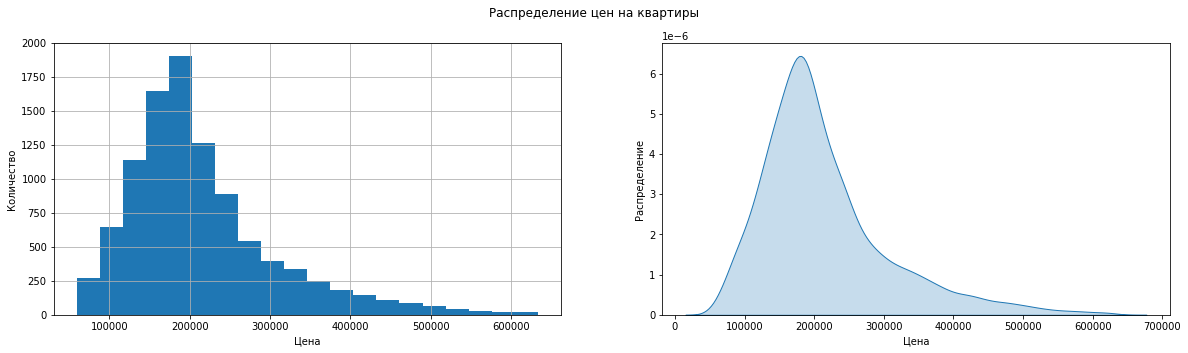

In [1780]:
plt.figure(figsize = (20, 5))

plt.subplot(121)
data_train['Price'].hist(density=False, bins=20)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(data_train['Price'], shade=True, legend=False)
plt.ylabel('Распределение')
plt.xlabel('Цена')

plt.suptitle('Распределение цен на квартиры')
plt.show()

Посмотрим распределение по количеству комнат

(0.0, 6.0)

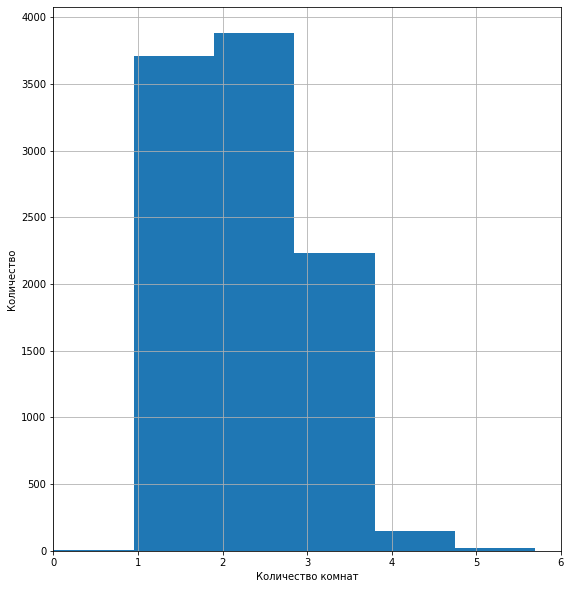

In [1781]:
plt.figure(figsize = (20, 10))

plt.subplot(121)
data_train['Rooms'].hist(density=False, bins=20)
plt.ylabel('Количество')
plt.xlabel('Количество комнат')
plt.xlim(0, 6)

In [1782]:
data_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

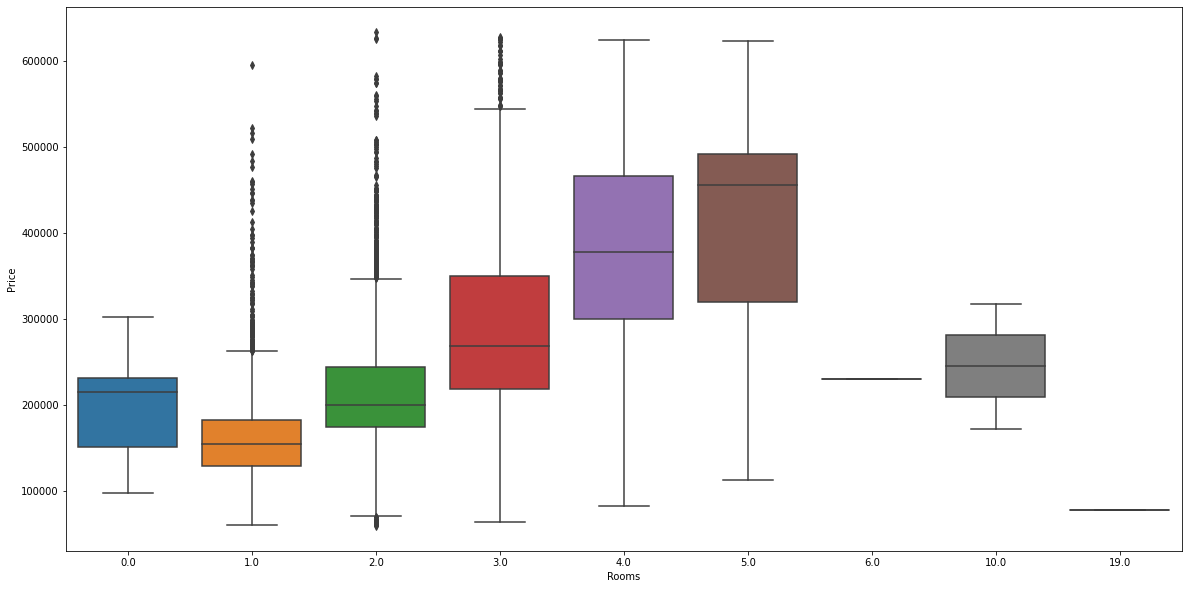

In [1783]:
plt.figure(figsize = (20, 10))
sns.boxplot(data = data_train, y = 'Price', x = 'Rooms')

Видим, что есть квартиры по 6, 10 и 19 комнат, но их цена и площадь выглядят ненастоящими, как выбросы или опечатки. Уберем их (возможно так делать нельзя, но предполагаю, что это повысит точность предсказания)

In [1784]:
data_train = data_train[(data_train.Rooms < 6)]

Теперь соотношение цены и количества комнат более закономерно

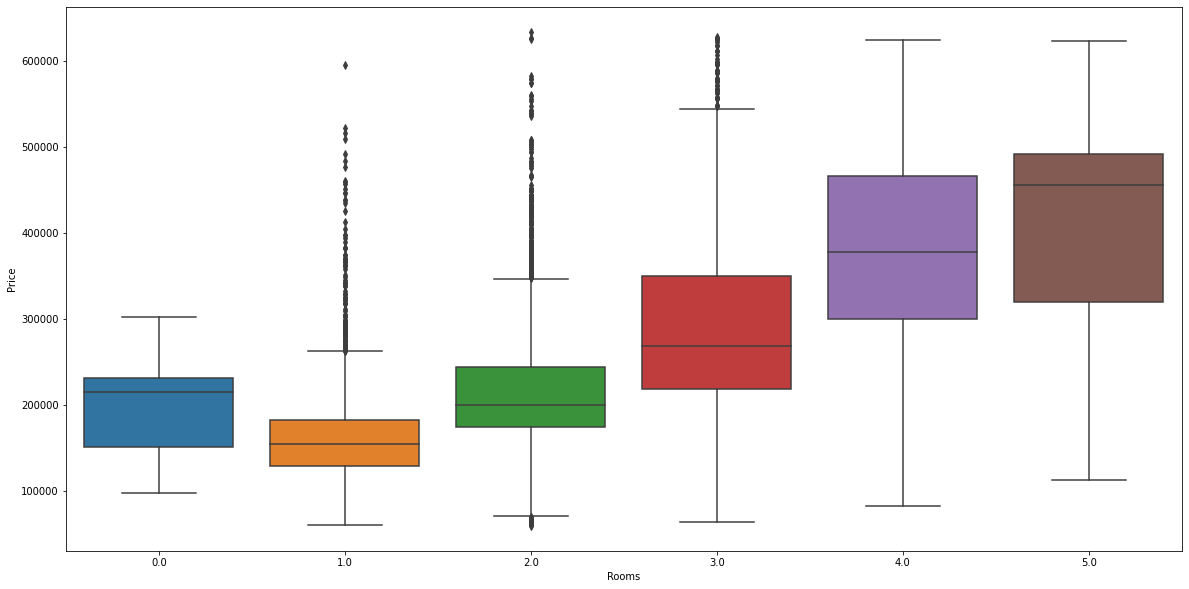

In [1785]:
plt.figure(figsize = (20, 10))
sns.boxplot(data = data_train, y = 'Price', x = 'Rooms')

Так же есть 1824 квартиры, которые расположены на "несуществующем" этаже, но мы не будем корректировать этот признак, так как он не оказывает такого существенного влияния на цену

In [1786]:
floors = pd.DataFrame(data_train['HouseFloor'] - data_train['Floor'])
floors[floors[0] < 0]

,0
7,-14.0
14,-1.0
16,-1.0
21,-14.0
23,-2.0
...,...
9984,-2.0
9985,-9.0
9989,-2.0
9991,-1.0


Построим матрицу корреляции

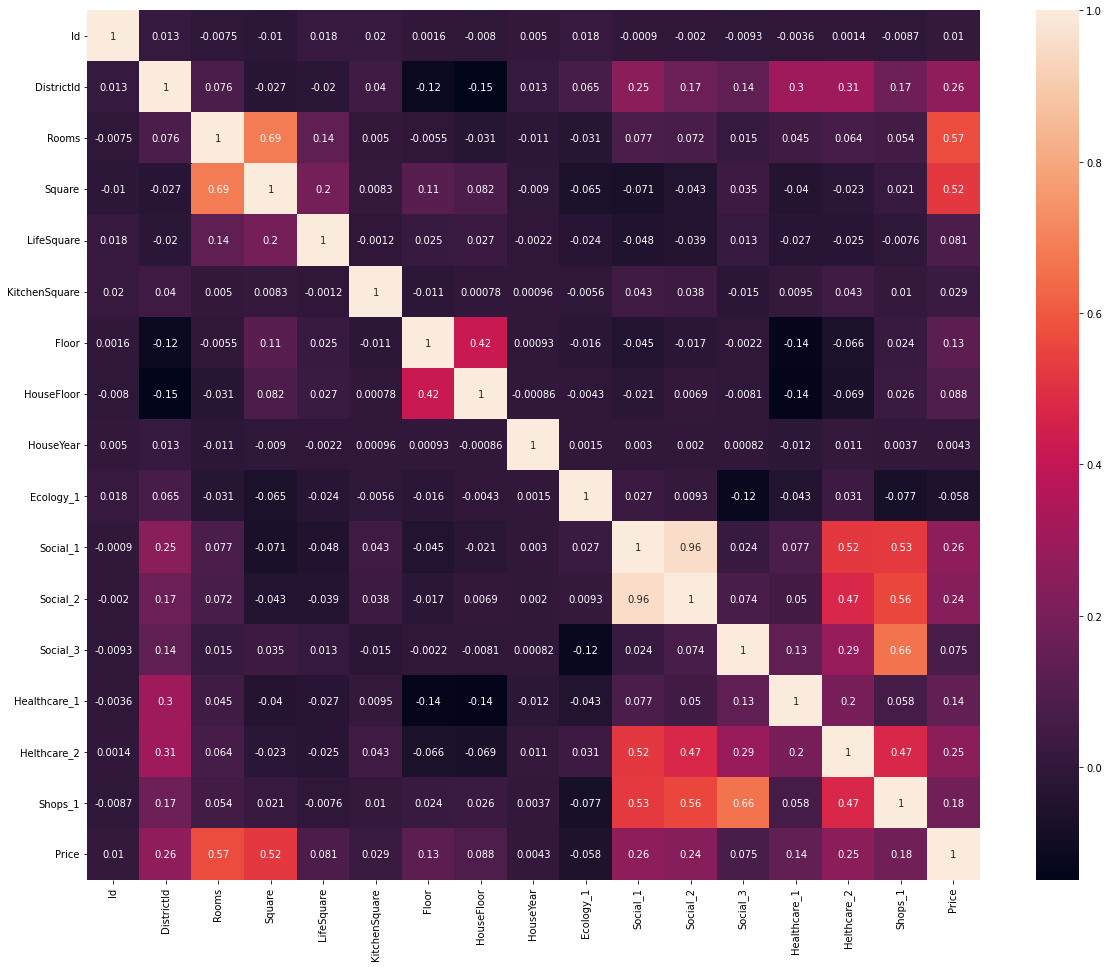

In [1787]:
plt.figure(figsize = (20, 16))
corr = data_train.corr()
sns.heatmap(corr, annot = True)

Видим, что цена в наибольшей степени зависит от площади жилья и количества комнат

Для каждой строки вычисляем отношение жилой площади к общей

In [1788]:
data_train['LifeSquare_count'] = data_train['LifeSquare']/data_train['Square']

Берем среднее значение отношения жилой площади к общей

In [1789]:
mean_LifeSquare_count = data_train['LifeSquare_count'].mean()
mean_LifeSquare_count

0.6659163816418942

Заменяем пропущенные значения в столбце "Жилая площадь" при помощи вычисленного среднего отношения 

In [1790]:
data_train.loc[:, 'LifeSquare'].fillna(data_train['Square']*mean_LifeSquare_count, inplace=True)

Забираем целевые значения в Y

In [1791]:
Y = pd.DataFrame(data_train['Price'], columns=["Price"])

Убираем из датасета целевое значение и вспомогательный столбец

In [1792]:
data_train.drop('LifeSquare_count', axis = 1, inplace=True)
data_train.drop('Price', axis = 1, inplace=True)

Также есть пропуски в столбце Healthcare_1. Попробуем для каждого района заменить их на самый частый показатель. Если для какого-либо района нет ни одного значения, то заменим на среднее по всем районам

In [1793]:
mean_Healthcare_1 = data_train['Healthcare_1'].mean() # среднее значение Healthcare_1
mean_Healthcare_1

1143.0840384615385

In [1794]:
Healthcare_1_fillna(data_train, mean_Healthcare_1)

Разделим датасет на train и valid

In [1795]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(data_train)

In [1796]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train, Y, test_size=0.3)

In [1797]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_valid_scaled = scaler.transform(X_valid)

In [1798]:
X_train.shape

(6997, 19)

In [1799]:
X_valid.shape

(2999, 19)

In [1800]:
y_train.shape

(6997, 1)

In [1801]:
y_valid.shape

(2999, 1)

In [1802]:
data_train.columns.values

array(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare',
       'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
       'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2'], dtype=object)

Брала линейную регрессию, но у меня она получила очень плохой результат, включать не стала

Зададим параметры для перебора в GridSearchCV

In [1803]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 15),
}

In [1804]:
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=100), param_grid=parameters, scoring='r2', cv=5)

Перебираем параметры в поисках наилучших (работает минут 10, поэтому пусть будет закоменчено)

In [1805]:
#grid_search.fit(X_train, y_train);

In [1806]:
#grid_search.best_params_

Создаем модель с подобранными параметрами

In [1807]:
model = RandomForestRegressor(n_estimators = 250, max_depth = 14, max_features = 5)

Обучаем ее на тренировочных данных

In [1808]:
model.fit(X_train, y_train.values[:, 0])

RandomForestRegressor(max_depth=14, max_features=5, n_estimators=250)

Посмотрим, насколько отличаются предсказанные и имеющиеся данные

In [1809]:
y_predict_RFR = model.predict(X_valid)

In [1810]:
checking = pd.DataFrame({
    "y_valid": y_valid["Price"],
    "y_predict_RFR": y_predict_RFR.flatten(),
})

checking.head(10)

,y_valid,y_predict_RFR
6699,212801.122972,220546.773049
343,522197.035995,414505.679848
5573,162283.825316,181622.161128
9162,438459.651986,262510.168355
8595,552454.338658,342365.912224
7495,201501.534582,189988.666829
6783,149194.221639,153711.149857
7516,557202.351363,402184.448235
6394,89917.923051,191604.447756
7094,132930.266226,144734.448106


In [1811]:
checking["error"] = checking["y_predict_RFR"] - checking["y_valid"]

checking.head(10)

,y_valid,y_predict_RFR,error
6699,212801.122972,220546.773049,7745.650078
343,522197.035995,414505.679848,-107691.356147
5573,162283.825316,181622.161128,19338.335813
9162,438459.651986,262510.168355,-175949.483631
8595,552454.338658,342365.912224,-210088.426434
7495,201501.534582,189988.666829,-11512.867754
6783,149194.221639,153711.149857,4516.928218
7516,557202.351363,402184.448235,-155017.903128
6394,89917.923051,191604.447756,101686.524705
7094,132930.266226,144734.448106,11804.181881


Рассчитаем коэффициент детерминации

In [1812]:
R2 = r2_score(checking["y_valid"], checking["y_predict_RFR"])
R2

0.7131367496074379

#Испробуем модель на тестовых данных

Заменяем буквенные значения на числовые, как в train

In [1813]:
abc_replace(data_test)

Заполняем пропущенные значения, как в train

In [1814]:
Healthcare_1_fillna(data_test, mean_Healthcare_1)

In [1815]:
data_test.loc[:, 'LifeSquare'].fillna(data_test['Square']*mean_LifeSquare_count, inplace=True)

In [1816]:
y_predict_RFR = model.predict(data_test)

In [1817]:
y_predict_RFR = pd.DataFrame(data=y_predict_RFR)
y_predict_RFR

,0
0,165707.896198
1,221228.469305
2,216774.069400
3,337257.699463
4,143143.940387
...,...
4995,256281.533048
4996,133454.631074
4997,323725.607951
4998,197227.436097


In [1818]:
id = pd.DataFrame(data_test['Id'])
id

,Id
0,725
1,15856
2,5480
3,15664
4,14275
...,...
4995,8180
4996,4695
4997,5783
4998,4780


In [1819]:
prediction = pd.concat([id, y_predict_RFR], axis = 1, ignore_index=True)
prediction.columns = ['Id', 'Price']

In [1820]:
prediction.to_csv('/content/Alekseeva_predictions.csv', index=False)